In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

In [28]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred) # 오차행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    f1 = f1_score(y_test, pred) # F1 score
    roc = roc_auc_score(y_test, pred_proba) # AUC
    
    print(f'오차행렬 : \n{confusion}\n\nTN = {confusion[0, 0]}, FP = {confusion[0, 1]}\nFN = {confusion[1, 0]}, TP = {confusion[1, 1]}\n')
    print(f'정확도 : {round(accuracy, 4)} \n정밀도 : {round(precision, 4)} \n재현율 : {round(recall, 4)} \nF1 score : {round(f1, 4)} \nAUC : {round(roc, 4)}')

##### [과제] 임계값을 0 ~ 1로 변경시킬 때 precision과 recall의 변화 추세를 시각화하여 출력하세요
---

In [85]:
tdf = pd.read_csv('../data/tdf.csv', index_col = 0)

X_train, X_test, y_train, y_test = train_test_split(tdf.drop('Survived', axis = 1), tdf['Survived'], test_size = 0.2, random_state = 444)
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
pred_proba = rf_clf.predict_proba(X_test)[:, 1]

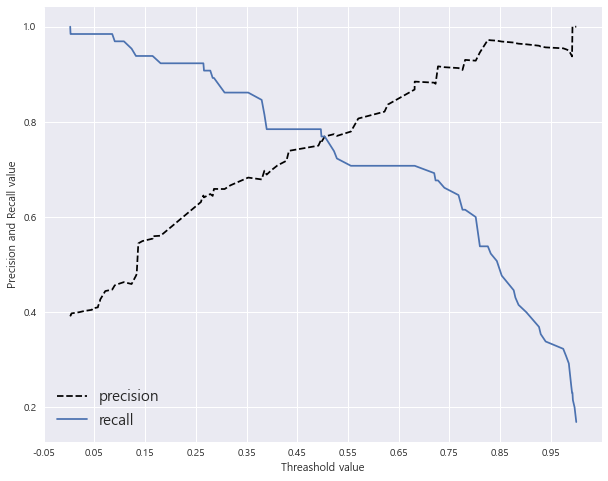

In [88]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    plt.figure(figsize =(10, 8))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], 'k--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlabel('Threashold value'); plt.ylabel('Precision and Recall value')
    plt.legend(fontsize = 15);
    plt.show()

precision_recall_curve_plot(y_test, pred_proba)

##### [과제] train.csv 파일을 불러와서 분류모델링 평가를 아래와 같이 수행하세요.
---
- dt 모델을 적용하고 GridSearchCV를 사용, 교차검증과 성능 개선을 위한 하이퍼파라미터 튜닝
- accuracy에 추가하여 confusion matrix, accuracy, precision, recall, roc auc score 평가


In [67]:
tdf = pd.read_csv('../data/tdf.csv', index_col = 0)

X_train, X_test, y_train, y_test = train_test_split(tdf.drop('Survived', axis = 1), tdf['Survived'], test_size = 0.2, random_state = 11, stratify = tdf['Survived'])
# rf_clf = RandomForestClassifier()
# rf_clf.fit(X_train, y_train)
# pred = rf_clf.predict(X_test)
# pred_proba = rf_clf.predict_proba(X_test)[:, 1]

dt_clf = DecisionTreeClassifier()
parameters = {'max_depth': [2, 3, 3, 4, 4], 'min_samples_split': [2, 2, 3, 3, 4]}
grid = GridSearchCV(dt_clf, param_grid = parameters, cv = 15, refit = True)
grid.fit(X_train, y_train)

print('GridSearchCV 최적 파라미터 :', grid.best_params_)
print(f'GridSearchCV 최고 정확도 : {grid.best_score_.round(3)}\n') 
estimator = grid.best_estimator_
pred = estimator.predict(X_test)
pred_proba = estimator.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

GridSearchCV 최적 파라미터 : {'max_depth': 4, 'min_samples_split': 2}
GridSearchCV 최고 정확도 : 0.823

오차행렬 : 
[[100  10]
 [ 14  55]]

TN = 100, FP = 10
FN = 14, TP = 55

정확도 : 0.8659 
정밀도 : 0.8462 
재현율 : 0.7971 
F1 score : 0.8209 
AUC : 0.9118


##### [과제] diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.
---
- SkinThickness 와 Insulin의 0 값은 상당히 많기 때문에 일괄 삭제가 어려우며 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가
- 데이터 세트는 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터
- 고립된 지역에서 인디언 고유의 혈통이 지속돼 왔지만 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자 발생\
$$$$

※ 피처 정보
- 'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압), 'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값), 'Insulin'(혈청 인슈린), 'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'
 

In [59]:
ddf = pd.read_csv('../data/diabetes.csv')

def transform(df):
    df1 = df.copy()
    mmscaler = MinMaxScaler()
    stdscaler = StandardScaler()
    for i in df.columns[[3, 4]]:
        df1.loc[df1[i] == 0, i] = df1[i].mean()
#     for i in df.columns[[0, 7]]:
#     for i in df1.columns[[0, 1, 2, 3, 4, 5, 7]]:
#         df1[i] = mmscaler.fit_transform(np.array(df1[i]).reshape(-1 ,1))
# #     for i in df.columns[[1, 2, 3, 4, 5]]:
    for i in df.columns[[0, 1, 2, 3, 4, 5, 7]]:
        df1[i] = stdscaler.fit_transform(np.array(df1[i]).reshape(-1, 1))
    return df1
    
ddf = transform(ddf)
ddf

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.848324,0.149641,0.872057,-0.417768,0.204013,0.627,1.425995,1
1,-0.844885,-1.123396,-0.160546,0.248678,-0.417768,-0.684422,0.351,-0.190672,0
2,1.233880,1.943724,-0.263941,-0.630654,-0.417768,-1.103255,0.672,-0.105584,1
3,-0.844885,-0.998208,-0.160546,-0.374700,-0.265107,-0.494043,0.167,-1.041549,0
4,-1.141852,0.504055,-1.504687,0.872057,0.530423,1.409746,2.288,-0.020496,1
...,...,...,...,...,...,...,...,...,...
763,1.827813,-0.622642,0.356432,2.222711,0.659428,0.115169,0.171,2.532136,0
764,-0.547919,0.034598,0.046245,0.040885,-0.417768,0.610154,0.340,-0.531023,0
765,0.342981,0.003301,0.149641,-0.374700,-0.071599,-0.735190,0.245,-0.275760,0
766,-0.844885,0.159787,-0.470732,-0.630654,-0.417768,-0.240205,0.349,1.170732,1


In [65]:
def precision_recall_curve_plot(y_test, pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    plt.figure(figsize =(10, 8))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], 'k--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlabel('Threashold value'); plt.ylabel('Precision and Recall value')
    plt.legend(fontsize = 15);
    plt.show()

def get_eval_by_threshold(y_test, pred_proba_reshape, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold)
        custom_predict = binarizer.fit_transform(pred_proba_reshape)
        print('임계값 :', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba)
        print('')

모델 : DecisionTreeClassifier(random_state=7)
오차행렬 : 
[[82 18]
 [26 28]]

TN = 82, FP = 18
FN = 26, TP = 28

정확도 : 0.7143 
정밀도 : 0.6087 
재현율 : 0.5185 
F1 score : 0.56 
AUC : 0.6693


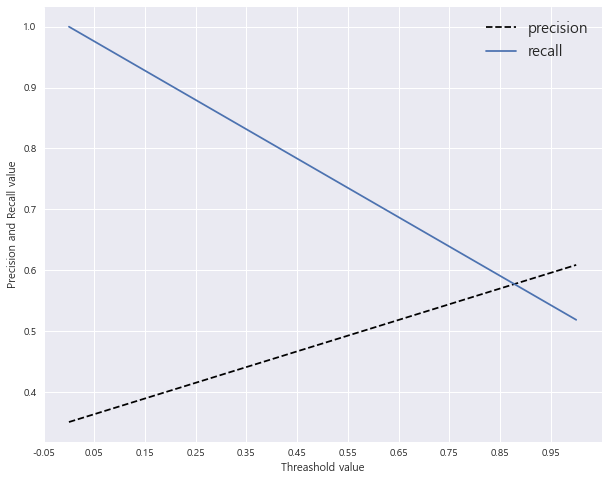

모델 : RandomForestClassifier(random_state=7)
오차행렬 : 
[[86 14]
 [24 30]]

TN = 86, FP = 14
FN = 24, TP = 30

정확도 : 0.7532 
정밀도 : 0.6818 
재현율 : 0.5556 
F1 score : 0.6122 
AUC : 0.8348


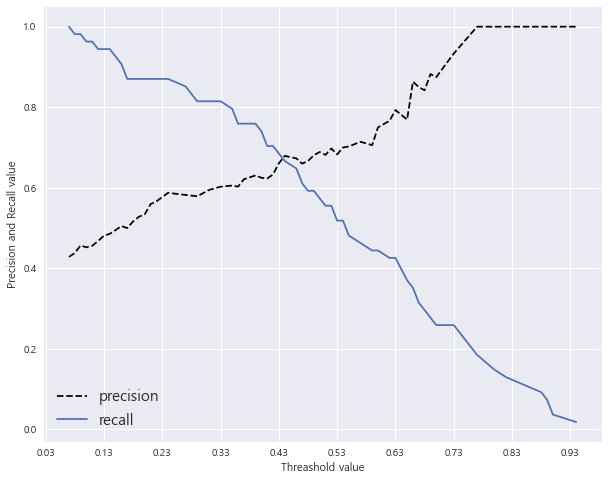

모델 : LogisticRegression(random_state=7)
오차행렬 : 
[[88 12]
 [24 30]]

TN = 88, FP = 12
FN = 24, TP = 30

정확도 : 0.7662 
정밀도 : 0.7143 
재현율 : 0.5556 
F1 score : 0.625 
AUC : 0.8454


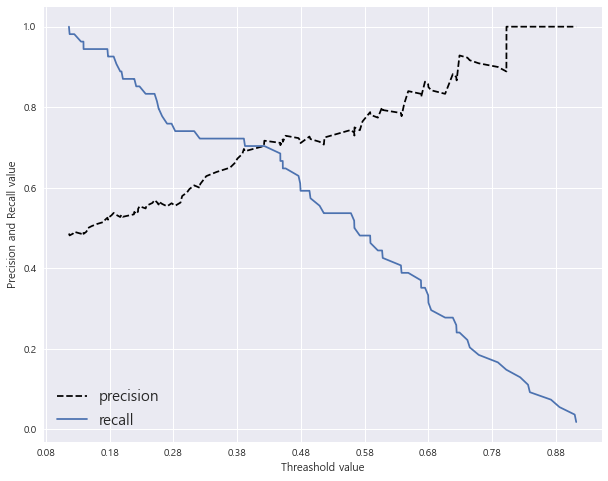

In [61]:
random_state = 7
X_train, X_test, y_train, y_test = train_test_split(ddf.drop('Outcome', axis = 1), ddf['Outcome'], test_size = 0.2, random_state = random_state, stratify = ddf['Outcome'])

dt_clf = DecisionTreeClassifier(random_state = random_state)
rf_clf = RandomForestClassifier(random_state = random_state)
lr_clf = LogisticRegression(random_state = random_state)

for clf in [dt_clf, rf_clf, lr_clf]:
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)[:, 1]
    
    print('모델 :', clf)
    get_clf_eval(y_test, pred, pred_proba)
    precision_recall_curve_plot(y_test, pred_proba)

In [63]:
thresholds = np.arange(0.3, 0.45, 0.03)

for clf in [dt_clf, rf_clf, lr_clf]:
    clf.fit(X_train, y_train)
#     pred = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)[:, 1]
    print('ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ')
    print('모델 :', clf)
    get_eval_by_threshold(y_test, pred_proba.reshape(-1, 1), thresholds)
    print('ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ')

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
모델 : DecisionTreeClassifier(random_state=7)
임계값 : 0.3
오차행렬 : 
[[82 18]
 [26 28]]

TN = 82, FP = 18
FN = 26, TP = 28

정확도 : 0.7143 
정밀도 : 0.6087 
재현율 : 0.5185 
F1 score : 0.56 
AUC : 0.6693

임계값 : 0.32999999999999996
오차행렬 : 
[[82 18]
 [26 28]]

TN = 82, FP = 18
FN = 26, TP = 28

정확도 : 0.7143 
정밀도 : 0.6087 
재현율 : 0.5185 
F1 score : 0.56 
AUC : 0.6693

임계값 : 0.35999999999999993
오차행렬 : 
[[82 18]
 [26 28]]

TN = 82, FP = 18
FN = 26, TP = 28

정확도 : 0.7143 
정밀도 : 0.6087 
재현율 : 0.5185 
F1 score : 0.56 
AUC : 0.6693

임계값 : 0.3899999999999999
오차행렬 : 
[[82 18]
 [26 28]]

TN = 82, FP = 18
FN = 26, TP = 28

정확도 : 0.7143 
정밀도 : 0.6087 
재현율 : 0.5185 
F1 score : 0.56 
AUC : 0.6693

임계값 : 0.4199999999999999
오차행렬 : 
[[82 18]
 [26 28]]

TN = 82, FP = 18
FN = 26, TP = 28

정확도 : 0.7143 
정밀도 : 0.6087 
재현율 : 0.5185 
F1 score : 0.56 
AUC : 0.6693

임계값 : 0.44999999999999984
오차행렬 : 
[[82 18]
 [26 28]]

TN = 82, FP = 18
FN = 26, TP = 28

정확도 : 0.7143 
정밀도 : 0.6087 
재현율 : 0.5185 
F1 s

In [64]:
random_state = 7
X_train, X_test, y_train, y_test = train_test_split(ddf.drop('Outcome', axis = 1), ddf['Outcome'], test_size = 0.2, random_state = random_state, stratify = ddf['Outcome'])

dt_clf = DecisionTreeClassifier(random_state = random_state)
rf_clf = RandomForestClassifier(random_state = random_state)
lr_clf = LogisticRegression(random_state = random_state)

for clf in [dt_clf, rf_clf, lr_clf]:
    clf.fit(X_train, y_train)
    pred_proba = clf.predict_proba(X_test)[:, 1]
    binarizer_re = Binarizer(threshold = 0.39)
    pred_re = binarizer_re.fit_transform(pred_proba.reshape(-1, 1))
    print('모델 :', clf)
    get_clf_eval(y_test, pred_re, pred_proba)
    print('')

모델 : DecisionTreeClassifier(random_state=7)
오차행렬 : 
[[82 18]
 [26 28]]

TN = 82, FP = 18
FN = 26, TP = 28

정확도 : 0.7143 
정밀도 : 0.6087 
재현율 : 0.5185 
F1 score : 0.56 
AUC : 0.6693

모델 : RandomForestClassifier(random_state=7)
오차행렬 : 
[[76 24]
 [14 40]]

TN = 76, FP = 24
FN = 14, TP = 40

정확도 : 0.7532 
정밀도 : 0.625 
재현율 : 0.7407 
F1 score : 0.678 
AUC : 0.8348

모델 : LogisticRegression(random_state=7)
오차행렬 : 
[[83 17]
 [15 39]]

TN = 83, FP = 17
FN = 15, TP = 39

정확도 : 0.7922 
정밀도 : 0.6964 
재현율 : 0.7222 
F1 score : 0.7091 
AUC : 0.8454



##### [과제] 백화점 고객의 1년 간 구매 데이터를 활용하여 고객 3,500명에 대한 학습용 데이터(y_train.csv, X_train.csv)를 이용, 성별예측 모형을 만든 후, 이를 평가용 데이터(X_test.csv)에 적용하여 얻은 2,482명 고객의 성별 예측값(남자일 확률)을 다음과 같은 형식의 CSV 파일로 생성하시오.(제출한 모델의 성능은 ROC-AUC 평가지표에 따라 채점)
---
(가) 제공 데이터 목록
$$$$
① y_train.csv : 고객의 성별 데이터 (학습용), CSV 형식의 파일\
② X_train.csv, X_test.csv : 고객의 상품구매 속성 (학습용 및 평가용), CSV 형식의 파일
$$$$

(나) 데이터 형식 및 내용\
① y_train.csv (3,500명 데이터)\
② X_train.csv (3,500명 데이터), X_test.csv (2,482명 데이터)
$$$$

custid, gender\
3500, 0.267\
3501, 0.578\
3502, 0.885

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

X_train = pd.read_csv('../data/X_train.csv', encoding = 'cp949', index_col = 0).fillna(0)
X_test = pd.read_csv('../data/X_test.csv', encoding = 'cp949', index_col = 0).fillna(0)
y_train = pd.read_csv('../data/y_train.csv', encoding = 'cp949', index_col = 0)

a = list(X_train['주구매상품'].value_counts().index)
b = list(X_test['주구매상품'].value_counts().index)
for i in a:
    if i not in b:
        X_test[f'주구매상품_{i}'] = 0

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
pred_proba = rf.predict_proba(X_test)

In [39]:
y_train.value_counts(normalize = True)

gender
0         0.624
1         0.376
dtype: float64

In [8]:
y_pred = X_test.drop(X_test.columns, axis = 1)
y_pred['gender'] = pred_proba[:, 1]
y_pred = y_pred.reset_index()
y_pred.to_csv('../data/y_pred.csv')

In [41]:
len(y_pred[y_pred['gender'] >= 0.5])/len(y_pred)

0.2832393231265109

In [7]:
import re

rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

score = cross_validate(rf, X_train, y_train, 
                       scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                       cv = 10)

for i, j  in zip(list(score.keys())[2:], list(score.values())[2:]):
    i = re.sub('test_', '', i)
    print(i, ':', round(np.mean(j), 3))

accuracy : 0.639
precision : 0.53
recall : 0.335
f1 : 0.41
roc_auc : 0.646
